# Lab 3 - report, Michał Błaszczak [245047]

# Task 1 (Grid search for simple exponential smoothing)

In [180]:
import numpy as np
import pandas as pd
from statsmodels.tsa.api import SimpleExpSmoothing, Holt
import matplotlib.pyplot as plt

### import data

In [181]:
df = pd.read_pickle('AlgerianExport.pkl')
df.head()

,Export
1960-12-31,39.043173
1961-12-31,46.244557
1962-12-31,19.793873
1963-12-31,24.684682
1964-12-31,25.084059


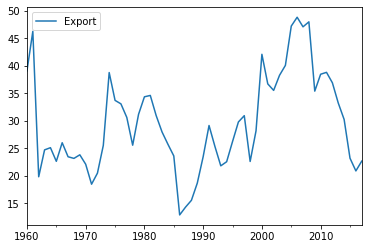

In [182]:
df.plot().legend()

In [183]:
len(df)

58

### define SES function

In [184]:
def SES(df, alpha):
    SES_array = np.array([39.043173, ])
    for i in range(0, 57):
        value = alpha * df.iloc[i][0] + (1 - alpha) * SES_array[i]
        SES_array = np.append(SES_array, value)
    
    index = pd.date_range(start="1960", end="2018", freq="Y")
    SES_df = pd.DataFrame(SES_array, columns = ['Exports'])
    SES_df = SES_df.set_index(index)
    
    return mean_squared_error(df, SES_df)

### determine alpha with the smallest MSE

In [185]:
alphas = np.arange(0.75, 1.00, 0.01)
for i in alphas:
    alpha = i
    MSE = SES(df=df, alpha=i)
    print('alpha:', round(i, 2), '   MSE:', round(MSE, 3))

alpha: 0.75    MSE: 34.636
alpha: 0.76    MSE: 34.587
alpha: 0.77    MSE: 34.544
alpha: 0.78    MSE: 34.506
alpha: 0.79    MSE: 34.475
alpha: 0.8    MSE: 34.45
alpha: 0.81    MSE: 34.43
alpha: 0.82    MSE: 34.416
alpha: 0.83    MSE: 34.408
alpha: 0.84    MSE: 34.406
alpha: 0.85    MSE: 34.409
alpha: 0.86    MSE: 34.417
alpha: 0.87    MSE: 34.432
alpha: 0.88    MSE: 34.451
alpha: 0.89    MSE: 34.476
alpha: 0.9    MSE: 34.507
alpha: 0.91    MSE: 34.543
alpha: 0.92    MSE: 34.584
alpha: 0.93    MSE: 34.631
alpha: 0.94    MSE: 34.684
alpha: 0.95    MSE: 34.742
alpha: 0.96    MSE: 34.805
alpha: 0.97    MSE: 34.874
alpha: 0.98    MSE: 34.949
alpha: 0.99    MSE: 35.029


In [186]:
#best result (smallest MSE) is for alpha = 0.84, where MSE: 34.406

### fit and forecast data using library models

In [187]:
fit = SimpleExpSmoothing(df, initialization_method="estimated").fit()
a = fit.model.params["smoothing_level"]
fcast = fit.forecast(3).rename(r"$\alpha=%s$" % a)
MSE = mean_squared_error(df, fit.fittedvalues)
print('MSE:', round(MSE, 3))

MSE: 34.401


### plot results

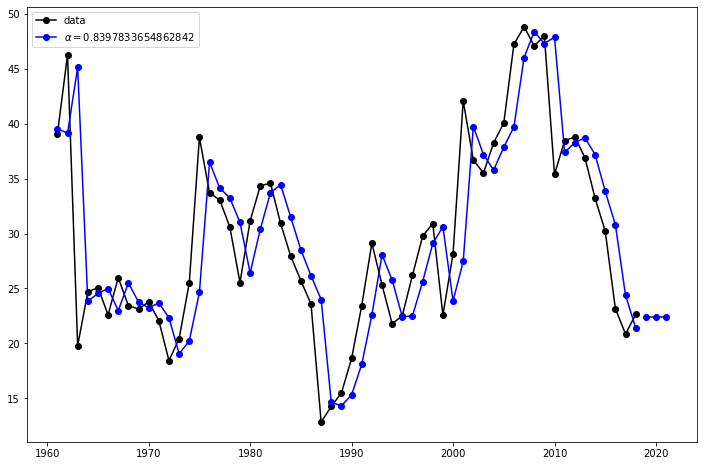

In [188]:
plt.figure(figsize=(12,8))
(line0, ) = plt.plot(df, marker="o", color="black")
plt.plot(fit.fittedvalues, marker="o", color="blue")
(line1, ) = plt.plot(fcast, marker="o", color="blue")

plt.legend([line0, line1], ['data', fcast.name])

# Task 2 (Time series forecasting workflow)

### read dataframe saved earlier using df.to_pickle('AlgerianExport.pkl')

In [189]:
df = pd.read_pickle('AlgerianExport.pkl')

In [190]:
df.head(5)

,Export
1960-12-31,39.043173
1961-12-31,46.244557
1962-12-31,19.793873
1963-12-31,24.684682
1964-12-31,25.084059


In [191]:
df.size

58

### divide data into train and test

In [192]:
ncut=int(0.8*df.size) # 80% for training the rest is withheld for testing
ncut

46

In [193]:
train_data=df.iloc[:ncut]
test_data=df.iloc[ncut:]

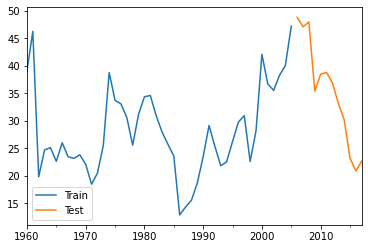

In [194]:
ax=train_data.plot()
test_data.plot(ax=ax)
ax.legend(['Train','Test'])

### fit the model

In [195]:
fitted_model=SimpleExpSmoothing(train_data,initialization_method='estimated').fit()

In [196]:
test_predictions=fitted_model.forecast(test_data.size).rename('SES forecast')

### evaluate the model

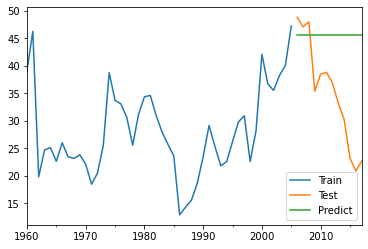

In [197]:
ax=train_data.plot()
test_data.plot(ax=ax)
test_predictions.plot(ax=ax)
ax.legend(['Train','Test','Predict'])

### evaluate metrics

In [198]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import  mean_absolute_error,mean_absolute_percentage_error

##### MSE

In [199]:
mean_squared_error(test_data,test_predictions)

192.04697370873177

In [200]:
np.sum(np.square(np.subtract(test_data["Export"].values,test_predictions.values)))/test_data.size

192.04697370873177

##### MAE

In [201]:
mean_absolute_error(test_data,test_predictions)

11.439487998291211

##### MAPE

In [202]:
mean_absolute_percentage_error(test_data,test_predictions)

0.4216657162083754

In [203]:
np.sum(np.divide(np.abs(np.subtract(test_data["Export"].values,test_predictions.values)),test_data["Export"].values))/12

0.4216657162083754

### future forecasting

##### let us assume that the model presented above turned out to be the best; we train the final model using all available data points

In [204]:
# we use all available data
final_model=SimpleExpSmoothing(df,initialization_method='estimated').fit()
forecast=final_model.forecast(test_data.size).rename('forecast')

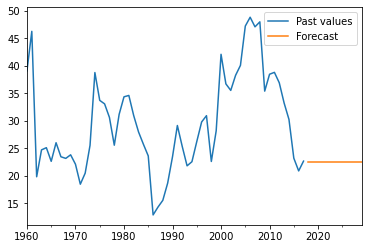

In [205]:
ax=df.plot()
forecast.plot(ax=ax)
ax.legend(['Past values','Forecast'])

# Task 3 (Holt’s method : double exponential smoothing)

### read data

In [206]:
df = pd.read_csv('IBM.csv', index_col='Date', parse_dates=True)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1962-02-01,6.978967,7.087317,6.978967,7.068196,1.577107,674670
1962-02-02,7.068196,7.112811,7.036329,7.112811,1.587062,533460
1962-02-05,7.112811,7.112811,6.985341,7.023582,1.567153,329490
1962-02-06,7.023582,7.036329,6.998088,7.029955,1.568788,274575
1962-02-07,7.036329,7.074570,7.036329,7.036329,1.570211,266730
...,...,...,...,...,...,...
1965-12-23,8.022626,8.022626,7.950924,7.950924,1.781072,301248
1965-12-27,7.966858,8.038560,7.966858,7.966858,1.784643,364008
1965-12-28,7.966858,8.002709,7.919057,8.002709,1.792673,382836


### choose close prices only

In [207]:
df = df['Close']
df

Date
1962-02-01    7.068196
1962-02-02    7.112811
1962-02-05    7.023582
1962-02-06    7.029955
1962-02-07    7.036329
                ...   
1965-12-23    7.950924
1965-12-27    7.966858
1965-12-28    8.002709
1965-12-29    7.934990
1965-12-30    7.966858
Name: Close, Length: 985, dtype: float64

### plot close price data

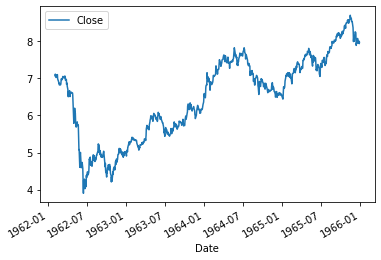

In [208]:
df.plot().legend()

### set the frequency of the time series to business days

In [209]:
df = df.asfreq('b')
df.index

DatetimeIndex(['1962-02-01', '1962-02-02', '1962-02-05', '1962-02-06',
               '1962-02-07', '1962-02-08', '1962-02-09', '1962-02-12',
               '1962-02-13', '1962-02-14',
               ...
               '1965-12-17', '1965-12-20', '1965-12-21', '1965-12-22',
               '1965-12-23', '1965-12-24', '1965-12-27', '1965-12-28',
               '1965-12-29', '1965-12-30'],
              dtype='datetime64[ns]', name='Date', length=1021, freq='B')

### use forward fill to remove nans

In [210]:
df = df.ffill(axis=0)
df

Date
1962-02-01    7.068196
1962-02-02    7.112811
1962-02-05    7.023582
1962-02-06    7.029955
1962-02-07    7.036329
                ...   
1965-12-24    7.950924
1965-12-27    7.966858
1965-12-28    8.002709
1965-12-29    7.934990
1965-12-30    7.966858
Freq: B, Name: Close, Length: 1021, dtype: float64

### select part of the time series for which the long-term linear trend is apparent - at this point I will stick to Friday's [18 March] lecture notes

In [211]:
ncut=int(0.8*len(df))
ncut

816

In [212]:
train_data = df.iloc[:ncut]
test_data = df.iloc[ncut:]

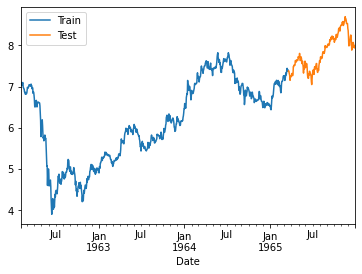

In [213]:
ax = train_data.plot()
test_data.plot(ax=ax)
ax.legend(['Train', 'Test'])

### fit and forecast Simple Exponential Smoothing model

In [214]:
fitSES = SimpleExpSmoothing(train_data).fit()
fcastSES = fitSES.forecast(len(test_data)).rename('SES predict')

### fit and forecast Holt model

In [215]:
fitHolt = Holt(train_data, exponential=False).fit()
fcastHolt = fitHolt.forecast(len(test_data)).rename('Holt predict')

### compare SES and Holt

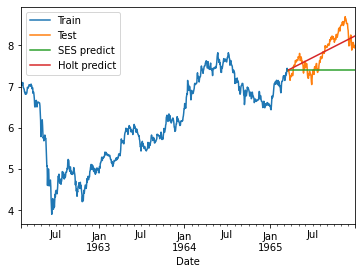

In [216]:
ax = train_data.plot()
test_data.plot(ax=ax)
fcastSES.plot(ax=ax)
fcastHolt.plot(ax=ax)
ax.legend(['Train', 'Test', 'SES predict', 'Holt predict'])

In [217]:
print("Mean Absolute Percentage Errors:")
SES_mape = mean_absolute_percentage_error(test_data, fcastSES)*100
print("  ", SES_mape, "%")
Holt_mape = mean_absolute_percentage_error(test_data, fcastHolt)*100
print("  ", Holt_mape, "%")

Mean Absolute Percentage Errors:
   5.7993546222452865 %
   2.804980221395473 %
